In [1]:
import os
import time
import pickle


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error

In [2]:
DATA_PATH=r'..\data\raw\train.csv'
TEST_PATH=r'..\data\raw\test.csv'
TRAIN_DATA=r'..\data\processed\dataframe.pkl'
BASE_SUPMISSION=r'..\notebooks\submission.csv'

In [3]:
train_df=pd.read_pickle(TRAIN_DATA)

In [4]:
train_df.head(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,...,yearly_price_per_km_x,monthly_price_per_km_x,yearly_price_per_km_y,monthly_price_per_km_y,dayofweek_price_per_km,hourly_price_per_km,yearly_fare,monthly_fare,weekly_fare,hourly_fare
0,13.0,2015-04-28 14:53:14 UTC,-73.963570,40.771313,-73.978333,40.751076,1,2015,4,28,...,4.26,3.76,4.26,3.76,3.76,4.08,13.05,11.32,11.38,11.90
1,24.5,2013-03-16 22:10:15 UTC,-73.985932,40.778404,-73.996953,40.722665,2,2013,3,16,...,4.08,3.76,4.08,3.76,3.75,3.45,12.63,11.19,11.36,11.29
2,6.9,2010-07-30 23:12:10 UTC,-74.008468,40.720306,-73.991503,40.736797,1,2010,7,30,...,3.45,3.63,3.45,3.63,3.76,3.39,10.03,11.09,11.33,11.58
3,8.5,2012-11-27 20:57:00 UTC,-73.970175,40.753165,-73.993177,40.746402,6,2012,11,27,...,3.65,3.82,3.65,3.82,3.76,3.63,11.20,11.55,11.43,10.75
4,16.0,2012-11-09 16:40:44 UTC,-73.959817,40.782076,-73.977885,40.736664,1,2012,11,9,...,3.65,3.82,3.65,3.82,3.77,3.91,11.20,11.55,11.24,11.89


In [5]:
print(train_df.columns)
features_i_used=['trip_harv_dis','trip_euclian_dis','year','month','yearly_fare','hourly_fare','monthly_price_per_km_x','yearly_price_per_km_x']
features_i_used

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day', 'hour', 'minute', 'trip_harv_dis', 'trip_euclian_dis',
       'fare/km', 'yearly_price_per_km_x', 'monthly_price_per_km_x',
       'yearly_price_per_km_y', 'monthly_price_per_km_y',
       'dayofweek_price_per_km', 'hourly_price_per_km', 'yearly_fare',
       'monthly_fare', 'weekly_fare', 'hourly_fare'],
      dtype='object')


['trip_harv_dis',
 'trip_euclian_dis',
 'year',
 'month',
 'yearly_fare',
 'hourly_fare',
 'monthly_price_per_km_x',
 'yearly_price_per_km_x']

In [6]:
def calculate_bearing(pickup_lat, pickup_long, dropoff_lat, dropoff_long):
    delta_lon = np.radians(dropoff_long - pickup_long)
    pickup_lat = np.radians(pickup_lat)
    dropoff_lat = np.radians(dropoff_lat)

    x = np.sin(delta_lon) * np.cos(dropoff_lat)
    y = np.cos(pickup_lat) * np.sin(dropoff_lat) - \
        np.sin(pickup_lat) * np.cos(dropoff_lat) * np.cos(delta_lon)
    bearing = np.arctan2(x, y)
    return np.degrees(bearing) % 360
def add_bearing(df):
    df["bearing"]=calculate_bearing( df.pickup_latitude,df.pickup_longitude, df.dropoff_latitude, df.dropoff_longitude)


In [7]:
def manhattan_distance(df):
    df['manhattan_distance']=np.abs(df['dropoff_latitude']-df['pickup_latitude'])+np.abs(df['dropoff_longitude']-df['pickup_longitude'])

In [8]:
add_bearing(train_df)
manhattan_distance(train_df)

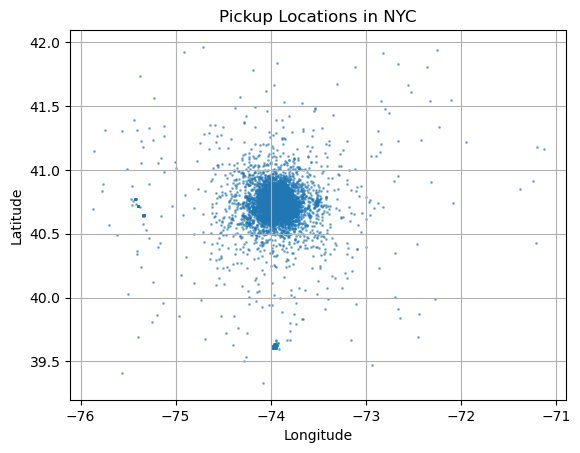

In [9]:
plt.scatter(train_df['pickup_longitude'], train_df['pickup_latitude'],s=1,  alpha=0.5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Pickup Locations in NYC")
plt.grid(True)


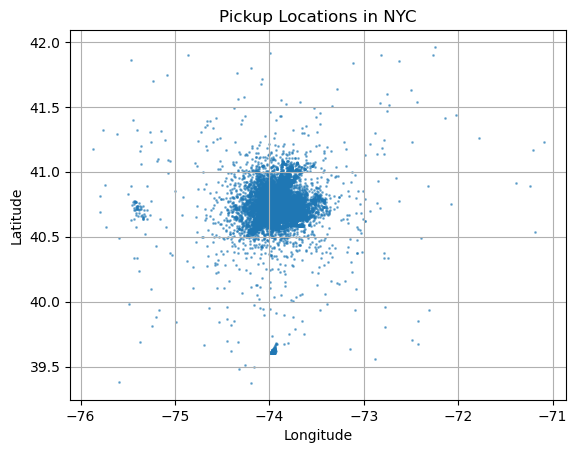

In [10]:
plt.scatter(train_df['dropoff_longitude'], train_df['dropoff_latitude'],s=1,  alpha=0.5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Pickup Locations in NYC")
plt.grid(True)

In [11]:
#bucket coordinates into area using clusters
train_df[['pickup_latitude', 'pickup_longitude']]

,pickup_latitude,pickup_longitude
0,40.771313,-73.963570
1,40.778404,-73.985932
2,40.720306,-74.008468
3,40.753165,-73.970175
4,40.782076,-73.959817
...,...,...
4759545,40.793042,-73.971071
4759546,40.758099,-73.988289
4759547,40.742635,-73.984467
4759548,40.765430,-73.954360


In [12]:
kmeans=KMeans(n_clusters=20,random_state=42)
kmeans.fit(train_df[['pickup_latitude', 'pickup_longitude']])

KMeans(n_clusters=20, random_state=42)

In [13]:
train_df['pickup_cluster'] = kmeans.predict(train_df[['pickup_latitude', 'pickup_longitude']])


In [112]:
filename='cluster_model.sav'
pickle.dump(kmeans,open(filename,'wb'))

In [14]:
train_df['pickup_cluster']

0          16
1           7
2           4
3           5
4           2
           ..
4759545     7
4759546    12
4759547     0
4759548    16
4759549    18
Name: pickup_cluster, Length: 4759550, dtype: int32

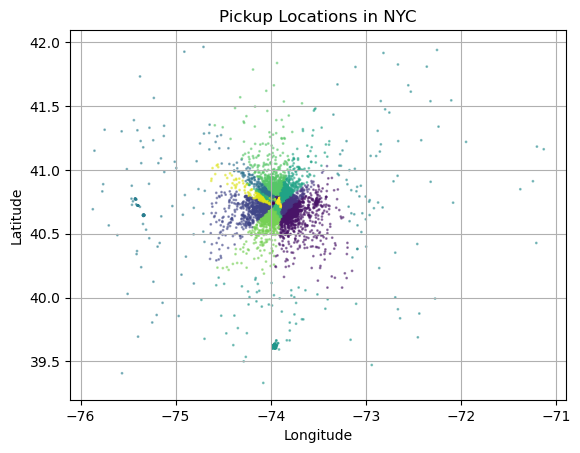

In [15]:
plt.scatter(train_df['pickup_longitude'], train_df['pickup_latitude'],s=1, c=train_df['pickup_cluster'], alpha=0.5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Pickup Locations in NYC")
plt.grid(True)

In [15]:
dropoff_coords = train_df[['dropoff_latitude', 'dropoff_longitude']].copy()
dropoff_coords.columns = ['pickup_latitude', 'pickup_longitude']  # match original training names

# Now predict clusters
train_df['dropoff_cluster'] = kmeans.predict(dropoff_coords)

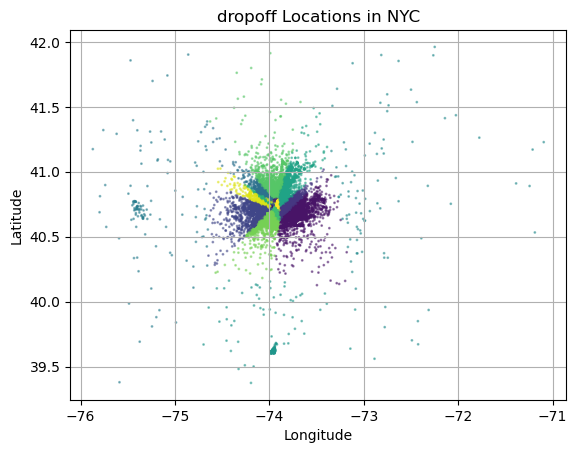

In [17]:
plt.scatter(train_df['dropoff_longitude'], train_df['dropoff_latitude'],s=1, c=train_df['dropoff_cluster'], alpha=0.5)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("dropoff Locations in NYC")
plt.grid(True)

In [16]:
train_df['is_night']=train_df['hour'].isin([0,1,2,3,4])
train_df['is_rush']=train_df['hour'].isin([8,9,15,16,17,18,19])
train_df['is_group'] = train_df['passenger_count'] > 1


In [17]:
train_df.head(5)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,...,monthly_fare,weekly_fare,hourly_fare,bearing,manhattan_distance,pickup_cluster,dropoff_cluster,is_night,is_rush,is_group
0,13.0,2015-04-28 14:53:14 UTC,-73.963570,40.771313,-73.978333,40.751076,1,2015,4,28,...,11.32,11.38,11.90,208.927707,0.035000,16,5,False,False,False
1,24.5,2013-03-16 22:10:15 UTC,-73.985932,40.778404,-73.996953,40.722665,2,2013,3,16,...,11.19,11.36,11.29,188.522507,0.066760,7,6,False,False,True
2,6.9,2010-07-30 23:12:10 UTC,-74.008468,40.720306,-73.991503,40.736797,1,2010,7,30,...,11.09,11.33,11.58,37.934123,0.033456,4,0,False,False,False
3,8.5,2012-11-27 20:57:00 UTC,-73.970175,40.753165,-73.993177,40.746402,6,2012,11,27,...,11.55,11.43,10.75,248.795881,0.029765,5,12,False,False,True
4,16.0,2012-11-09 16:40:44 UTC,-73.959817,40.782076,-73.977885,40.736664,1,2012,11,9,...,11.55,11.24,11.89,196.777061,0.063480,2,0,False,True,False


In [18]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4759550 entries, 0 to 4759549
Data columns (total 32 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   fare_amount             float64
 1   pickup_datetime         object 
 2   pickup_longitude        float64
 3   pickup_latitude         float64
 4   dropoff_longitude       float64
 5   dropoff_latitude        float64
 6   passenger_count         int64  
 7   year                    int32  
 8   month                   int32  
 9   day                     int32  
 10  hour                    int32  
 11  minute                  int32  
 12  trip_harv_dis           float64
 13  trip_euclian_dis        float64
 14  fare/km                 float64
 15  yearly_price_per_km_x   float64
 16  monthly_price_per_km_x  float64
 17  yearly_price_per_km_y   float64
 18  monthly_price_per_km_y  float64
 19  dayofweek_price_per_km  float64
 20  hourly_price_per_km     float64
 21  yearly_fare             float64

In [19]:
train_df[['is_night','is_rush','is_group']]=train_df[['is_night','is_rush','is_group']].astype(int)

In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4759550 entries, 0 to 4759549
Data columns (total 32 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   fare_amount             float64
 1   pickup_datetime         object 
 2   pickup_longitude        float64
 3   pickup_latitude         float64
 4   dropoff_longitude       float64
 5   dropoff_latitude        float64
 6   passenger_count         int64  
 7   year                    int32  
 8   month                   int32  
 9   day                     int32  
 10  hour                    int32  
 11  minute                  int32  
 12  trip_harv_dis           float64
 13  trip_euclian_dis        float64
 14  fare/km                 float64
 15  yearly_price_per_km_x   float64
 16  monthly_price_per_km_x  float64
 17  yearly_price_per_km_y   float64
 18  monthly_price_per_km_y  float64
 19  dayofweek_price_per_km  float64
 20  hourly_price_per_km     float64
 21  yearly_fare             float64

In [21]:
correlation_matrix=train_df.drop(['pickup_datetime','monthly_price_per_km_y','yearly_price_per_km_y'],axis=1).corr(method='pearson')

<Axes: >

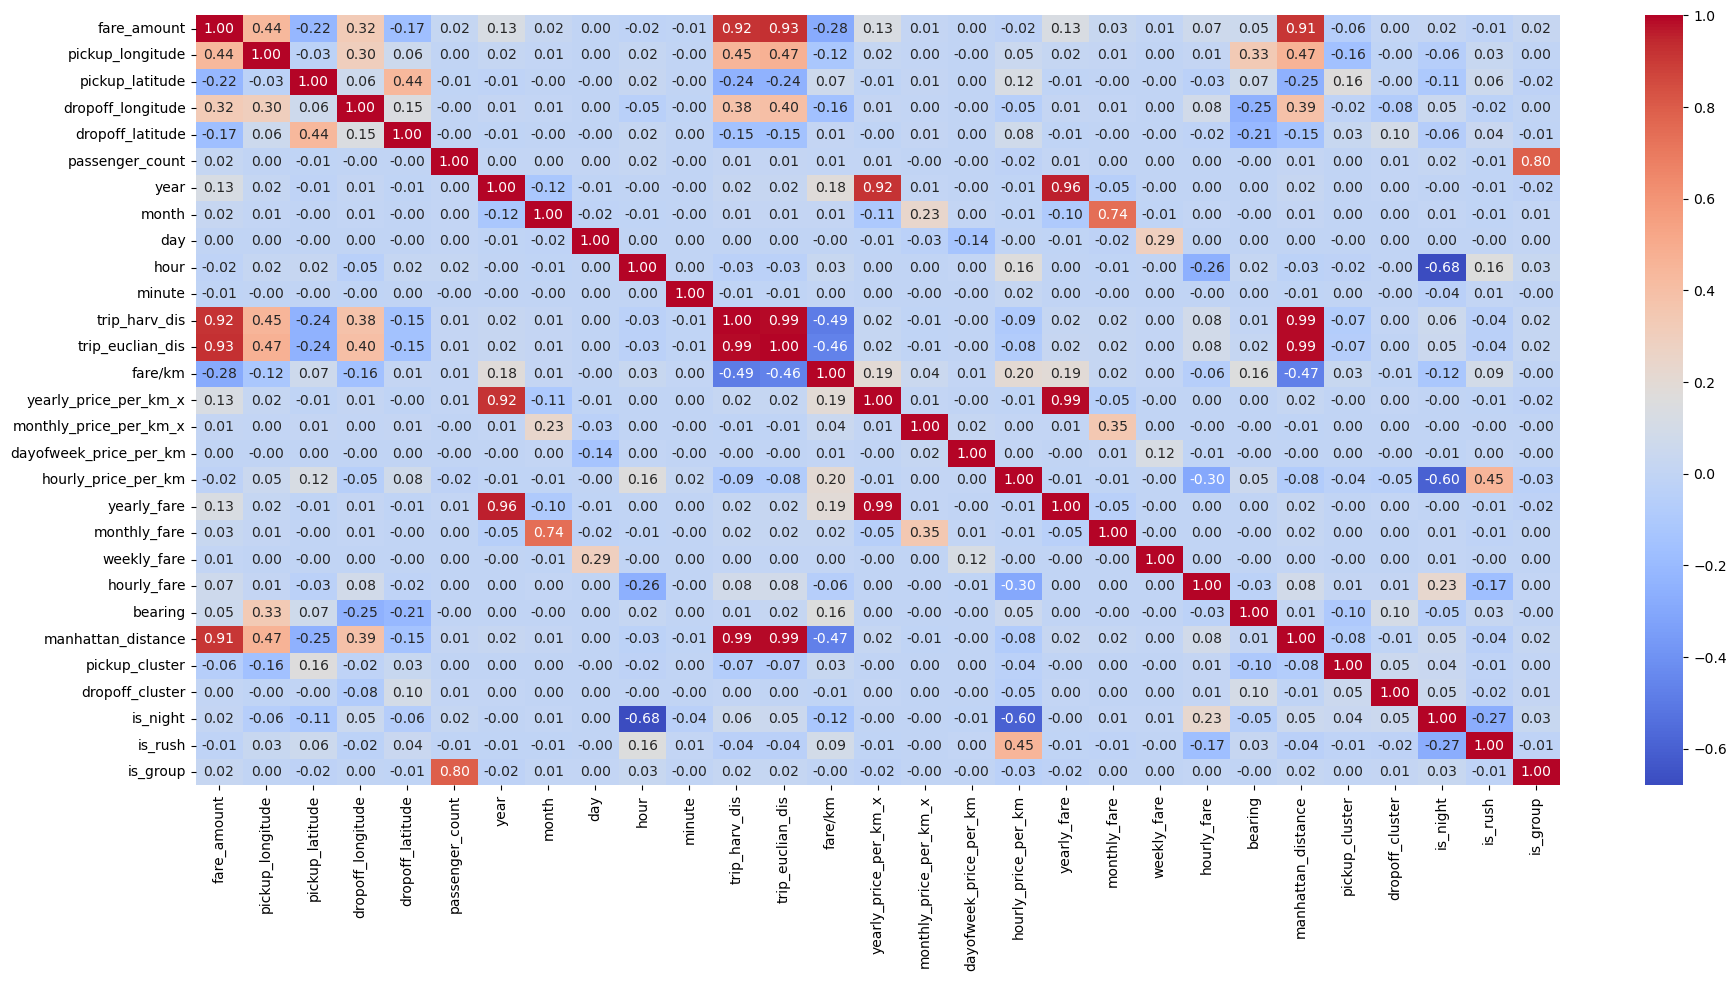

In [22]:
plt.figure(figsize=(22,10))
sns.heatmap(correlation_matrix,annot=True,cmap='coolwarm', fmt=".2f")

In [23]:
train_df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'year',
       'month', 'day', 'hour', 'minute', 'trip_harv_dis', 'trip_euclian_dis',
       'fare/km', 'yearly_price_per_km_x', 'monthly_price_per_km_x',
       'yearly_price_per_km_y', 'monthly_price_per_km_y',
       'dayofweek_price_per_km', 'hourly_price_per_km', 'yearly_fare',
       'monthly_fare', 'weekly_fare', 'hourly_fare', 'bearing',
       'manhattan_distance', 'pickup_cluster', 'dropoff_cluster', 'is_night',
       'is_rush', 'is_group'],
      dtype='object')

In [24]:
features=['passenger_count', 'year','month','hour','trip_harv_dis', 'trip_euclian_dis','manhattan_distance','yearly_price_per_km_x','hourly_fare', 'bearing','pickup_cluster','is_night','is_rush', 'is_group']

In [25]:
X=train_df[features]
y=train_df['fare_amount']
X_train2,X_test2,y_train2,y_test2=train_test_split(X,y,random_state=42,test_size=.2,shuffle=True)


In [26]:
import time

In [27]:
xgmodel=XGBRegressor()
start_time=time.time()
xgmodel.fit(X_train2,y_train2)
overall_time=time.time()-start_time

In [28]:
results={}
y_train_pred = xgmodel.predict(X_train2)
y_test_pred = xgmodel.predict(X_test2)

rmse_train = root_mean_squared_error(y_train2, y_train_pred)
rmse_test = root_mean_squared_error(y_test2, y_test_pred)
mape_train = mean_absolute_percentage_error(y_train2, y_train_pred)
mape_test = mean_absolute_percentage_error(y_test2, y_test_pred)
results['xgboost_model'] = {
            'RMSE_train': rmse_train,
            'RMSE_TEST': rmse_test,
            'mape_train':mape_train,
            'mape_test':mape_test,
            'training_time': overall_time
        }

In [29]:
results

{'xgboost_model': {'RMSE_train': 2.5796410512938475,
  'RMSE_TEST': 2.6258687928494173,
  'mape_train': 0.1379446110863884,
  'mape_test': 0.13833984081323789,
  'training_time': 14.28367567062378}}

In [30]:
yearly_fare=pd.read_pickle(r'..\data\processed\temp\yearly_fare.pkl')
hourly_fare=pd.read_pickle(r'..\data\processed\temp\hourly_fare.pkl')
monthly_price_per_km=pd.read_pickle(r'..\data\processed\temp\monthly_price_per_km.pkl')
yearly_price_per_km=pd.read_pickle(r'..\data\processed\temp\yearly_price_per_km.pkl')

In [31]:
test_df=pd.read_csv(TEST_PATH)

In [32]:
test_df['key']=pd.to_datetime(test_df['key'])
test_df['year']=test_df['key'].dt.year
test_df['month']=test_df['key'].dt.month
test_df['day']=test_df['key'].dt.month

test_df['hour']=test_df['key'].dt.hour

In [33]:
test_df=test_df.merge(yearly_fare,on='year',how='left')
test_df=test_df.merge(hourly_fare,on='hour',how='left')
test_df=test_df.merge(monthly_price_per_km,on='month',how='left')
test_df=test_df.merge(yearly_price_per_km,on='year',how='left')


In [34]:
def harvesine_dis(lon1,lat1,lon2,lat2):
    R = 6371  # Earth radius in kilometers

    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi/2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c

def euclidean_distance(lon1, lat1, lon2, lat2):
    return np.sqrt((lat2 - lat1)**2 + (lon2 - lon1)**2)

def add_dis(df):
    df["trip_harv_dis"]=harvesine_dis(df.pickup_longitude, df.pickup_latitude, df.dropoff_longitude, df.dropoff_latitude)
    df["trip_euclian_dis"]=euclidean_distance(df.pickup_longitude, df.pickup_latitude, df.dropoff_longitude, df.dropoff_latitude)

add_dis(test_df)

In [35]:
test_df.rename(columns={"monthly_price_per_km": "monthly_price_per_km_x"}, inplace=True)
test_df.rename(columns={"yearly_price_per_km": "yearly_price_per_km_x"}, inplace=True)

In [36]:
add_bearing(test_df)
manhattan_distance(test_df)


In [37]:
test_df['pickup_cluster']=kmeans.predict(test_df[['pickup_latitude','pickup_longitude']])

In [38]:
temp_long_lat=test_df[['dropoff_latitude','dropoff_longitude']]
temp_long_lat.columns=['pickup_latitude','pickup_longitude']

In [39]:
test_df['dropoff_cluster']=kmeans.predict(temp_long_lat)

In [40]:
test_df['is_night']=test_df['hour'].isin([0,1,2,3,4])
test_df['is_rush']=test_df['hour'].isin([8,9,15,16,17,18,19])
test_df['is_group'] = test_df['passenger_count'] > 1


In [41]:
test_df

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,...,yearly_price_per_km_x,trip_harv_dis,trip_euclian_dis,bearing,manhattan_distance,pickup_cluster,dropoff_cluster,is_night,is_rush,is_group
0,2015-01-27 13:08:24.000000200,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1,2015,1,1,...,4.26,2.323260,0.021554,197.102591,0.028080,5,0,False,False,False
1,2015-01-27 13:08:24.000000300,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1,2015,1,1,...,4.26,2.425353,0.023180,335.311613,0.031841,6,18,False,False,False
2,2011-10-08 11:53:44.000000200,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1,2011,10,10,...,3.48,0.618628,0.005870,156.994148,0.007991,0,0,False,False,False
3,2012-12-01 21:12:12.000000200,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1,2012,12,12,...,3.65,1.961033,0.018649,203.513308,0.025460,17,12,False,False,False
4,2012-12-01 21:12:12.000000300,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1,2012,12,12,...,3.65,5.387301,0.050631,200.618451,0.067867,7,0,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.000000200,2015-05-10 12:37:51 UTC,-73.968124,40.796997,-73.955643,40.780388,6,2015,5,5,...,4.26,2.124874,0.020776,150.357203,0.029091,7,2,False,False,True
9910,2015-01-12 17:05:51.000000100,2015-01-12 17:05:51 UTC,-73.945511,40.803600,-73.960213,40.776371,6,2015,1,1,...,4.26,3.270969,0.030945,202.238753,0.041931,14,2,False,True,True
9911,2015-04-19 20:44:15.000000100,2015-04-19 20:44:15 UTC,-73.991600,40.726608,-73.789742,40.647011,6,2015,4,4,...,4.26,19.183941,0.216985,117.409509,0.281456,6,1,False,False,True
9912,2015-01-31 01:05:19.000000500,2015-01-31 01:05:19 UTC,-73.985573,40.735432,-73.939178,40.801731,6,2015,1,1,...,4.26,8.343486,0.080920,27.907235,0.112694,0,14,True,False,True


In [42]:
test_df[features]

,passenger_count,year,month,hour,trip_harv_dis,trip_euclian_dis,manhattan_distance,yearly_price_per_km_x,hourly_fare,bearing,pickup_cluster,is_night,is_rush,is_group
0,1,2015,1,13,2.323260,0.021554,0.028080,4.26,11.56,197.102591,5,False,False,False
1,1,2015,1,13,2.425353,0.023180,0.031841,4.26,11.56,335.311613,6,False,False,False
2,1,2011,10,11,0.618628,0.005870,0.007991,3.48,11.15,156.994148,0,False,False,False
3,1,2012,12,21,1.961033,0.018649,0.025460,3.65,11.03,203.513308,17,False,False,False
4,1,2012,12,21,5.387301,0.050631,0.067867,3.65,11.03,200.618451,7,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9909,6,2015,5,12,2.124874,0.020776,0.029091,4.26,11.15,150.357203,7,False,False,True
9910,6,2015,1,17,3.270969,0.030945,0.041931,4.26,11.48,202.238753,14,False,True,True
9911,6,2015,4,20,19.183941,0.216985,0.281456,4.26,10.75,117.409509,6,False,False,True
9912,6,2015,1,1,8.343486,0.080920,0.112694,4.26,11.36,27.907235,0,True,False,True


In [43]:
predictions=xgmodel.predict(test_df[features])

In [44]:
test_df2=pd.read_csv(TEST_PATH)

In [45]:
submission = pd.DataFrame({
    "key": test_df2["key"],
    "fare_amount": predictions
})

In [46]:
submission.to_csv('submission2.csv', index=False)  

trying grid search

In [50]:
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [ 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

In [51]:
grid_search=GridSearchCV(xgb_model,
                         param_grid=param_grid,
                         cv=3,
                        verbose=1,
                       n_jobs=-1  # Use all CPU cores
    )

In [52]:
grid_search.fit(X_train2, y_train2)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 1.0],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [200], 'subsample': [0.7, 1.0]},
             verbose=1)

In [53]:
grid_search.best_score_

0.9200525767704001

In [54]:
grid_search.best_params_

{'colsample_bytree': 1.0,
 'learning_rate': 0.1,
 'max_depth': 7,
 'n_estimators': 200,
 'subsample': 0.7}

In [55]:
y_train_pred2=grid_search.predict(X_train2)
y_test_pred2=grid_search.predict(X_test2)

In [56]:
rmse_train2 = root_mean_squared_error(y_train2, y_train_pred2)
rmse_test2 = root_mean_squared_error(y_test2, y_test_pred2)
mape_train2 = mean_absolute_percentage_error(y_train2, y_train_pred2)
mape_test2 = mean_absolute_percentage_error(y_test2, y_test_pred2)
results['xgboost_model_grid_search'] = {
            'RMSE_train': rmse_train2,
            'RMSE_TEST': rmse_test2,
            'mape_train':mape_train2,
            'mape_test':mape_test2,
            'training_time': overall_time
        }

In [57]:
results

{'xgboost_model': {'RMSE_train': 2.5796410512938475,
  'RMSE_TEST': 2.6258687928494173,
  'mape_train': 0.1379446110863884,
  'mape_test': 0.13833984081323789,
  'training_time': 14.28367567062378},
 'xgboost_model_grid_search': {'RMSE_train': 2.5431268747417435,
  'RMSE_TEST': 2.6148582287839135,
  'mape_train': 0.13679256168702048,
  'mape_test': 0.13730292157551513,
  'training_time': 14.28367567062378}}

In [ ]:
grid_search.predict(X_train2)
grid_search.predict(X_test2)

In [59]:
submission3 = pd.DataFrame({
    "key": test_df2["key"],
    "fare_amount": grid_search.predict(test_df[features])
})

In [60]:
submission3.to_csv('submission3.csv',index=False)

trying more features

In [ ]:
features2=features.copy()
features2.extend(['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'])
features2

['passenger_count',
 'year',
 'month',
 'hour',
 'trip_harv_dis',
 'trip_euclian_dis',
 'manhattan_distance',
 'yearly_price_per_km_x',
 'hourly_fare',
 'bearing',
 'pickup_cluster',
 'is_night',
 'is_rush',
 'is_group',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude']

In [70]:
X2=train_df[features2]
y2=train_df['fare_amount']
X_train3,X_test3,y_train3,y_test3=train_test_split(X2,y2,random_state=42,test_size=.2,shuffle=True)

In [84]:
xgb_model2=XGBRegressor()
xgb_model2.fit(X_train3,y_train3)
y_train_pred3=xgb_model2.predict(X_train3)
y_test_pred3=xgb_model2.predict(X_test3)


In [85]:
rmse_train3 = root_mean_squared_error(y_train3, y_train_pred3)
rmse_test3= root_mean_squared_error(y_test3, y_test_pred3)
mape_train3 = mean_absolute_percentage_error(y_train3, y_train_pred3)
mape_test3 = mean_absolute_percentage_error(y_test3, y_test_pred3)
results['xgboost_model_with_more_FE'] = {
            'RMSE_train': rmse_train3,
            'RMSE_TEST': rmse_test3,
            'mape_train':mape_train3,
            'mape_test':mape_test3,
            'training_time': overall_time
        }

In [86]:
pd.DataFrame(results)

,xgboost_model,xgboost_model_grid_search,xgboost_model_with_more_FE
RMSE_train,2.579641,2.543127,2.415940
RMSE_TEST,2.625869,2.614858,2.495479
mape_train,0.137945,0.136793,0.131942
mape_test,0.138340,0.137303,0.132502
training_time,14.283676,14.283676,14.283676


In [76]:
param_grid2 = {
    'n_estimators': [200,300],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1]
}

In [77]:
xgb_model3=XGBRegressor(random_state=42)


In [78]:
grid_search2=GridSearchCV(xgb_model3,
                         param_grid=param_grid2,
                         cv=3,
                        verbose=1,
                       n_jobs=-1  # Use all CPU cores
    )

In [79]:
grid_search2.fit(X_train3,y_train3)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 6],
                         'n_estimators': [200, 300]},
             verbose=1)

In [80]:
grid_search2.best_estimator_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [99]:
y_train_pred4=grid_search2.predict(X_train3)
y_test_pred4=grid_search2.predict(X_test3)


In [87]:
rmse_train4 = root_mean_squared_error(y_train3, y_train_pred4)
rmse_test4= root_mean_squared_error(y_test3, y_test_pred4)
mape_train4 = mean_absolute_percentage_error(y_train3, y_train_pred4)
mape_test4 = mean_absolute_percentage_error(y_test3, y_test_pred4)
results['xgboost_model_grid_search_again'] = {
            'RMSE_train': rmse_train4,
            'RMSE_TEST': rmse_test4,
            'mape_train':mape_train4,
            'mape_test':mape_test4,
            'training_time': overall_time
        }

In [88]:
pd.DataFrame(results)

,xgboost_model,xgboost_model_grid_search,xgboost_model_with_more_FE,xgboost_model_grid_search_again
RMSE_train,2.579641,2.543127,2.415940,2.400869
RMSE_TEST,2.625869,2.614858,2.495479,2.478070
mape_train,0.137945,0.136793,0.131942,0.130969
mape_test,0.138340,0.137303,0.132502,0.131516
training_time,14.283676,14.283676,14.283676,14.283676


In [89]:
submission4 = pd.DataFrame({
    "key": test_df2["key"],
    "fare_amount": grid_search2.predict(test_df[features2])
})

In [90]:
submission4.to_csv('submission4.csv',index=False)

In [92]:
X_train3

,passenger_count,year,month,hour,trip_harv_dis,trip_euclian_dis,manhattan_distance,yearly_price_per_km_x,hourly_fare,bearing,pickup_cluster,is_night,is_rush,is_group,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
3616363,4,2013,3,20,2.904737,0.028262,0.039451,4.08,10.75,28.605989,12,0,0,1,-73.995145,40.760157,-73.978627,40.783090
1695251,1,2010,11,22,5.628240,0.053281,0.072280,3.45,11.29,157.556655,17,0,0,0,-73.983582,40.763982,-73.958087,40.717197
3089377,1,2014,9,15,5.122531,0.047861,0.063412,4.17,12.01,199.075802,7,0,1,0,-73.968430,40.786632,-73.988302,40.743092
4260628,1,2012,4,5,2.501843,0.027157,0.037259,3.65,15.06,231.619257,2,0,0,0,-73.944988,40.778737,-73.968275,40.764765
3542497,3,2013,10,9,1.917082,0.018518,0.025708,4.08,10.90,207.088219,6,0,1,1,-73.991597,40.732167,-74.001955,40.716817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1136074,1,2015,1,15,2.960520,0.026637,0.027866,4.26,12.01,357.948053,12,0,1,0,-73.987762,40.747921,-73.989021,40.774529
1570006,1,2010,5,12,2.170297,0.024402,0.032042,3.45,11.15,299.517115,16,0,0,0,-73.958714,40.763795,-73.981142,40.773409
2234489,1,2011,10,10,4.325256,0.043175,0.060956,3.48,10.96,33.982386,6,0,0,0,-73.993553,40.731067,-73.964848,40.763318
4304572,1,2010,6,4,0.392907,0.003654,0.004790,3.45,13.49,162.234105,14,1,0,0,-73.940205,40.836984,-73.938780,40.833619


In [103]:
grid_search2.best_estimator_.predict([[4,2013,3,20,2.904737,	0.028262,0.039451,4.08,	10.75,28.605989,12,0,0,1,-73.995145,40.760157,-73.978627,40.783090]])

array([8.431395], dtype=float32)

saving the training model

In [107]:
filename='trained_model_xgboost.sav'
pickle.dump(grid_search2.best_estimator_,open(filename,'wb'))

loading the saved model

loading the saved model

In [108]:
loaded_model=pickle.load(open(filename,'rb'))

In [109]:
loaded_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [111]:
loaded_model.predict([[4,2013,3,20,2.904737,	0.028262,0.039451,4.08,	10.75,28.605989,12,0,0,1,-73.995145,40.760157,-73.978627,40.783090]])

array([8.431395], dtype=float32)

In [110]:
import streamlit as st


ModuleNotFoundError: No module named 'streamlit'

In [116]:
a={'a':1,'b':2}
pd.DataFrame(a,index=[0])

,a,b
0,1,2
